# **Producto Integrador de Aprendizaje**
---
Tema: **Entrenamiento de una CNN usando CIFAR-100**\
Inteligencia Artificial; IB


> 1877436, Jesús Emmanuel Guerrero Cortez \
> 1943543, Haziel Jair Sánchez Barrón \
> 1378118, Víctor Manuel Castañeda de León \
> 1841262, Bryan David Garrido \
> 1799686, Jesús Quezada Oviedo






In [1]:
import tensorflow as tf
#Importación de base de trabajo y librerías 
from tensorflow.keras import datasets, layers, models
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.applications.inception_v3 import InceptionV3
#VGG16 con fine-tuning, aunque puede ser empleado con cualquier modelo
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
#____________________________________________________________________#
from datetime import datetime
import pandas as pd
import numpy as np
import pytz
import matplotlib.pyplot as plt

#Arreglo se usará como registro, aunque bien se podrían enviar los valores a archivo csv.
historyarray = [0]

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar100.load_data(label_mode='coarse')
#Normalización (abajo) e importación del data set CIFAR100 (arriba), con conjuntos de prueba y entrenamiento.
train_images, test_images = train_images / 255.0, test_images / 255.0

169017344/169001437 [==============================] - 2s 0us/step


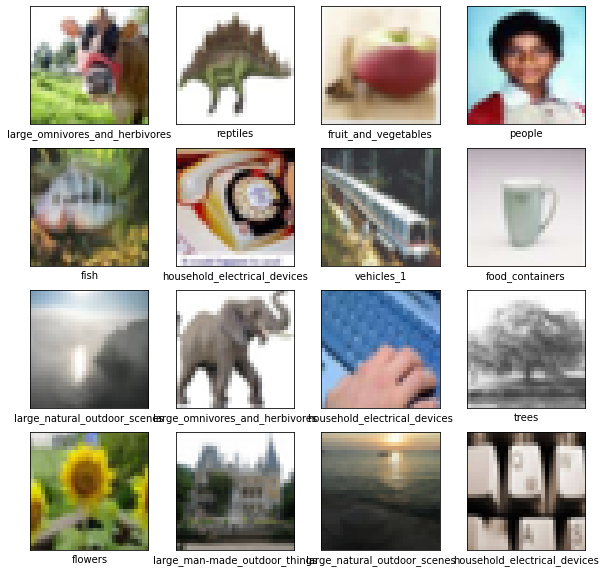

In [3]:
#Inicialmente, optamos por eliminar el arreglo de strings para etiquetas, puesto que equivaldría a 100 clases.
#Para evitar la fatiga de copiar y pegar, se procesaron los atributos a partir de un archivo csv (sep. por coma, tipo str); creado.
#Al final, para aumentar exactitud, se redujo la ultima capa profunda a 20 nodos, o superclases.
#Valores de shape de set de entrenamiento se usarán al trabajar con modelo de transfer learning.

'''
CIFAR100_attributes = pd.read_csv('https://pastebin.com/raw/qgDaNggt', sep=',', header=None).astype(str).values.tolist()[0]

'''
Coarse_labels = ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 
                'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 
                'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 
                'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']

data_size, img_rows, img_cols, img_channels = train_images.shape

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(Coarse_labels[train_labels[i][0]])
plt.show()

In [4]:
#Imágenes a RGB, 32x32x(3_canales); capas superficiales
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(512, (3, 3), activation='relu'))

In [5]:
#Modelo de capas profundas
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='sigmoid'))
model.add(layers.Dense(20))

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 256)         2

In [7]:
# Esta celda tiene por intención guardar el mejor modelo a partir del peso de sus características; solo tiene utilidad en fine-tuning
# ModelCheckpoint callback - guardar los mejores pesos (weights).
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# Si no existe cambio en la perdida durante la validación, se detiene.
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

In [8]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

#Aceleración con GPU (demasiado útil). Fundamentos disponibles en: https://colab.research.google.com/notebooks/gpu.ipynb#scrollTo=sXnDmXR7RDr2

tf.keras.optimizers.Adagrad(
    learning_rate=0.00005, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad"
)

tf.keras.optimizers.Adadelta(
    learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta"
)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

def train_model(model, epochs = 10, steps_per_epoch = 2, validation_steps = 1):
  history = model.fit(train_images, train_labels, epochs = epochs, steps_per_epoch = steps_per_epoch, validation_data = (test_images, test_labels), validation_steps = validation_steps, callbacks=[tl_checkpoint_1, early_stop])
  return(history)

Found GPU at: /device:GPU:0


In [9]:
SIMPLE_MODEL_history = train_model(model, 30, 40, 10)
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

Epoch 1/30
40/40 [==============================] - ETA: 0s - loss: 2.9529 - accuracy: 0.0802
Epoch 00001: val_loss improved from inf to 2.84584, saving model to tl_model_v1.weights.best.hdf5
40/40 [==============================] - 39s 177ms/step - loss: 2.9529 - accuracy: 0.0802 - val_loss: 2.8458 - val_accuracy: 0.1199
Epoch 2/30
40/40 [==============================] - ETA: 0s - loss: 2.7575 - accuracy: 0.1486
Epoch 00002: val_loss improved from 2.84584 to 2.69682, saving model to tl_model_v1.weights.best.hdf5
40/40 [==============================] - 5s 133ms/step - loss: 2.7575 - accuracy: 0.1486 - val_loss: 2.6968 - val_accuracy: 0.1777
Epoch 3/30
40/40 [==============================] - ETA: 0s - loss: 2.6416 - accuracy: 0.1883
Epoch 00003: val_loss improved from 2.69682 to 2.61969, saving model to tl_model_v1.weights.best.hdf5
40/40 [==============================] - 5s 133ms/step - loss: 2.6416 - accuracy: 0.1883 - val_loss: 2.6197 - val_accuracy: 0.1893
Epoch 4/30
40/40 [====

In [10]:
# Transfer learning: VGG16 entrenado usando ImageNet; se usa sin su top layer.
def init_VGG16_model(summary):
  VGG16_MODEL=tf.keras.applications.VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  # Habilitar conv layers
  VGG16_MODEL.trainable=True

  dropout_layer = tf.keras.layers.Dropout(rate = 0.2)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # Se sobrepone la top layer de CIFAR100 (dense de 20 neuronas, activación softmax para daterminación de clases = 1.0) junto con el model sequential de la red de transferencia
  prediction_layer = tf.keras.layers.Dense(len(Coarse_labels),activation='sigmoid')
  model = tf.keras.Sequential([VGG16_MODEL, dropout_layer, global_average_layer, prediction_layer])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

VGG16_MODEL = init_VGG16_model(summary = True)

58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 dropout (Dropout)           (None, 1, 1, 512)         0         
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_4 (Dense)             (None, 20)                10260     
                                                                 
Total params: 14,724,948
Trainable params: 14,724,948
Non-trainable params: 0
_________________________________________________________________


In [11]:
VGG16_MODEL_history = train_model(VGG16_MODEL, 20, 50, 10)
test_loss_VGG16, test_acc_VGG16 = model.evaluate(test_images, test_labels, verbose=2)

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 2.1816 - accuracy: 0.3218
Epoch 00001: val_loss improved from 1.72210 to 1.61423, saving model to tl_model_v1.weights.best.hdf5
50/50 [==============================] - 49s 693ms/step - loss: 2.1816 - accuracy: 0.3218 - val_loss: 1.6142 - val_accuracy: 0.4914
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 1.5022 - accuracy: 0.5254
Epoch 00002: val_loss improved from 1.61423 to 1.35423, saving model to tl_model_v1.weights.best.hdf5
50/50 [==============================] - 35s 701ms/step - loss: 1.5022 - accuracy: 0.5254 - val_loss: 1.3542 - val_accuracy: 0.5743
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 1.2829 - accuracy: 0.5904
Epoch 00003: val_loss improved from 1.35423 to 1.23977, saving model to tl_model_v1.weights.best.hdf5
50/50 [==============================] - 35s 701ms/step - loss: 1.2829 - accuracy: 0.5904 - val_loss: 1.2398 - val_accuracy: 0.6005
Epoch 4/20
50/50

In [12]:
# Transfer learning: VGG16 entrenado usando ImageNet; se usa sin su top layer, pero se añade fine-tuning (ver documento)
def init_VGG16_model_finetuning(summary, fine_tune=0):
  VGG16_MODEL_FT=tf.keras.applications.VGG16(input_shape=(img_rows, img_cols, img_channels), include_top=False, weights='imagenet')

  # Define cuántas capas se congelan durante el entrenamiento. Las capas de la base convolucional 
  # pasan de ser entrenables a no entrenables dependiendo del valor de fine-tuning.
  if fine_tune > 0:
    for layer in VGG16_MODEL_FT.layers[:-fine_tune]:
      layer.trainable = False
  else:
    for layer in VGG16_MODEL_FT.layers:
      layer.trainable = False

  top_model = VGG16_MODEL_FT.output
  top_model = Flatten(name="flatten")(top_model)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(1072, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)

  # Se sobrepone la top layer de CIFAR100 (dense de 20 neuronas, activación softmax para 
  # determinación de clases = 1.0) junto con el model sequential de la red de transferencia
  prediction_layer = Dense(len(Coarse_labels), activation='softmax')(top_model)
  model = tf.keras.Model(inputs=VGG16_MODEL_FT.input, outputs=prediction_layer)

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

VGG16_MODEL_FT = init_VGG16_model_finetuning(summary = True, fine_tune=2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [ ]:
VGG16_MODEL_FT_history = train_model(VGG16_MODEL_FT, 10, 100, 10)
test_loss_VGG16_FT, test_acc_VGG16_FT = model.evaluate(test_images, test_labels, verbose=1)

In [ ]:
# Esta celda se encargará de generar prediciones sobre la exactitud empleando el mejor modelo (sus características)
VGG16_MODEL_FT.load_weights('tl_model_v1.weights.best.hdf5')

true_classes = {A: B for A, B in zip(test_images, test_labels)}
class_indices = {A: B for A, B in zip(train_images, train_labels)}
class_indices = dict((v,k) for k,v in class_indices.items())

VGG16_PRED = VGG16_MODEL_FT.predict(test_images)
VGG16_PRED_Classes = np.argmax(VGG16_PRED, axis=1)

VGG16_ACCURACY_FT = accuracy_score(true_classes, VGG16_PRED_Classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(VGG16_ACCURACY_FT * 100))

In [ ]:
# Esta celda fue inhabilitada debido a la exhaustividad de procesamiento; SEGUIR LOS SIGUIENTES PASOS SI SE DESEA TRABAJAR CON ESTE MODELO PREENTRENADO.
 
# Trabajar con Inception (una arquitectura CNN más moderna que VGG16) implicaría ajustar la forma de la entrada de las bases de CIFAR100 a, por lo menos, 75x75x3. 
# Para ello se sugiere hacer uso del siguiente dataset que ha aplicado un reescalamiento (256x256) a las imágenes, sin causar en nuestra máquina un consumo excesivo de recursos.
    # https://www.kaggle.com/ibraheemmoosa/cifar100-256x256
# Es necesario, si se continúa empleando Colab, importar dicho dataset a la consola virtual. Para ello, recomendamos visualizar el siguiente link donde se detalla paso a paso su subida.
    # https://www.kaggle.com/ibraheemmoosa/cifar100-256x256
# Una vez logrado, deberemos ajustar el punto de carga, el input_shape del modelo (256x256x3) e hiperparámetros (de ser necesario). 
# Enseguida, se correrá esta celda. Notése que se han predefinido las dimensiones de la entrada. 

# Transfer learning: Inception (versión 3) entrenado usando ImageNet; se usa sin su top layer, al igual que el modelo preentrenado anterior.
def init_Inception_model(summary):
  Inception_MODEL = InceptionV3(input_shape=(256, 256, 3), include_top=False, weights='imagenet')

  # Habilitar conv layers
  Inception_MODEL.trainable=True

  dropout_layer = tf.keras.layers.Dropout(rate = 0.2)
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

  # Se sobrepone la top layer de CIFAR100 (dense de 20 neuronas, activación softmax para daterminación de clases = 1.0) junto con el model sequential de la red de transferencia
  prediction_layer = tf.keras.layers.Dense(len(Coarse_labels),activation='softmax')
  model = tf.keras.Sequential([Inception_MODEL, dropout_layer, global_average_layer, prediction_layer])

  model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.00005), loss=tf.keras.losses.sparse_categorical_crossentropy, metrics=["accuracy"])
  if summary: 
    model.summary()
  return model

Inception_MODEL = init_Inception_model(summary = True)

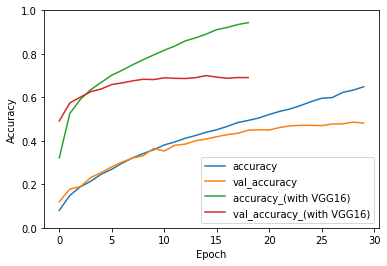

In [16]:
plt.plot(SIMPLE_MODEL_history.history['accuracy'], label='accuracy')
plt.plot(SIMPLE_MODEL_history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(VGG16_MODEL_history.history['accuracy'], label='accuracy_(with VGG16)')
plt.plot(VGG16_MODEL_history.history['val_accuracy'], label = 'val_accuracy_(with VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [17]:
#Arreglo de valores de exactitud para validación/testeo
tz_MX = pytz.timezone('America/Mexico_City')
now = datetime.now(tz_MX)
current_time = now.strftime("%d/%m/%Y a las %H:%M:%S")

historyarray.append(f'{current_time}: {round((test_acc * 100), 2)}%')

print(test_acc, historyarray)

0.48170000314712524 [0, '21/11/2021 a las 19:35:06: 48.17%']


**Consultas y sitios web**


```
1. https://www.programiz.com/python-programming/datetime/current-datetime
2. https://www.tensorflow.org/tutorials/images/cnn?hl=es-419
3. https://www.tensorflow.org/api_docs/python/tf/keras/activations?hl=es-419)
4. https://gist.github.com/heyalexej/8bf688fd67d7199be4a1682b3eec7568
5. https://neurohive.io/en/popular-networks/vgg16/
6. https://www.cs.toronto.edu/~kriz/cifar.html
7. https://towardsdatascience.com/cifar-100-pre-processing-for-image-recognition-task-68015b43d658
```

